In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features  # number of input features ie number of nodes
        self.out_features = out_features  # number of output features

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()  # initialize the weights and biases

    def reset_parameters(self):
        nn.init.xavier_uniform_(
            self.weight
        )  # initialize the weights using xavier uniform initialization
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, input, adj):

        support = torch.mm(
            input, self.weight
        )  # matrix multiplication of input and weight
        output = torch.spmm(
            adj, support
        )  # sparse matrix multiplication of adj and support

        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [35]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)  # first layer
        self.gc2 = GraphConvolution(nhid, nclass)  # second layer
        self.dropout = nn.Dropout(dropout)  # dropout layer

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.dropout(x)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [31]:
datapath = "data-cora/cora.content"

idx_features_labels = np.genfromtxt(datapath, dtype=np.dtype(str))

ids = np.array(idx_features_labels[:, 0], dtype=np.dtype(np.float32))
features = np.array(idx_features_labels[:, 1:-1], dtype=np.dtype(np.float32))
labels = np.array(idx_features_labels[:, -1], dtype=np.dtype(str))

onehot_labels_dict = {label: i for i, label in enumerate(np.unique(labels))}
print("Classes: ", onehot_labels_dict)
onehot_labels = np.array(
    [onehot_labels_dict[label] for label in labels], dtype=np.dtype(np.float32)
)

onehot_ids_dict = {id: i for i, id in enumerate(np.unique(ids))}
print("Number of papers: ", len(onehot_ids_dict.keys()))
onehot_ids = np.array([onehot_ids_dict[id] for id in ids], dtype=np.dtype(np.float32))

Classes:  {'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6}
Number of papers:  2708


In [29]:
datapath = "data-cora/cora.cites"

links = np.genfromtxt(datapath, dtype=np.dtype(np.float32))

adj = np.zeros(
    (len(onehot_ids_dict.keys()), len(onehot_ids_dict.keys())),
    dtype=np.dtype(np.float32),
)
for link in links:
    adj[onehot_ids_dict[link[0]], onehot_ids_dict[link[1]]] = 1
    adj[onehot_ids_dict[link[1]], onehot_ids_dict[link[0]]] = 1

In [33]:
from sklearn.model_selection import train_test_split

train_idxs,test_idxs = train_test_split(range(len(onehot_ids)), test_size=0.2, random_state=42)

train_idxs = np.array(train_idxs)
test_idxs = np.array(test_idxs)

features = torch.FloatTensor(features)
labels = torch.LongTensor(onehot_labels)
adj = torch.FloatTensor(adj)

train_features = features[train_idxs]
train_labels = labels[train_idxs]
train_adj = adj[train_idxs][:, train_idxs]

test_features = features[test_idxs]
test_labels = labels[test_idxs]
test_adj = adj[test_idxs][:, test_idxs]

In [71]:
EPOCHS = 200

model = GCN(
    nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, dropout=0.5
)
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss = []
test_loss = []
test_acc = []

for epoch in range(EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    output = model(train_features, train_adj)
    loss = F.nll_loss(output, train_labels) # negative log likelihood loss 
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    

    if epoch % 10 == 0:
        model.eval()
        output = model(test_features, test_adj)
        loss = F.nll_loss(output, test_labels)
        test_loss.append(loss.item())
        acc = torch.sum(torch.argmax(output, dim=1) == test_labels).item() / len(test_labels)
        test_acc.append(acc)
        print(f"Epoch: {epoch} - Train Loss: {loss.item():.2f} - Test Loss: {loss.item():.2f} - Test Accuracy: {acc:.2f}")
    
   

Epoch: 0 - Train Loss: 2.10 - Test Loss: 2.10 - Test Accuracy: 0.17
Epoch: 10 - Train Loss: 1.73 - Test Loss: 1.73 - Test Accuracy: 0.49
Epoch: 20 - Train Loss: 1.73 - Test Loss: 1.73 - Test Accuracy: 0.49
Epoch: 30 - Train Loss: 1.70 - Test Loss: 1.70 - Test Accuracy: 0.51
Epoch: 40 - Train Loss: 1.66 - Test Loss: 1.66 - Test Accuracy: 0.51
Epoch: 50 - Train Loss: 1.63 - Test Loss: 1.63 - Test Accuracy: 0.53
Epoch: 60 - Train Loss: 1.62 - Test Loss: 1.62 - Test Accuracy: 0.53
Epoch: 70 - Train Loss: 1.59 - Test Loss: 1.59 - Test Accuracy: 0.54
Epoch: 80 - Train Loss: 1.60 - Test Loss: 1.60 - Test Accuracy: 0.55
Epoch: 90 - Train Loss: 1.57 - Test Loss: 1.57 - Test Accuracy: 0.55
Epoch: 100 - Train Loss: 1.59 - Test Loss: 1.59 - Test Accuracy: 0.55
Epoch: 110 - Train Loss: 1.59 - Test Loss: 1.59 - Test Accuracy: 0.55
Epoch: 120 - Train Loss: 1.59 - Test Loss: 1.59 - Test Accuracy: 0.56
Epoch: 130 - Train Loss: 1.60 - Test Loss: 1.60 - Test Accuracy: 0.55
Epoch: 140 - Train Loss: 1.61 -

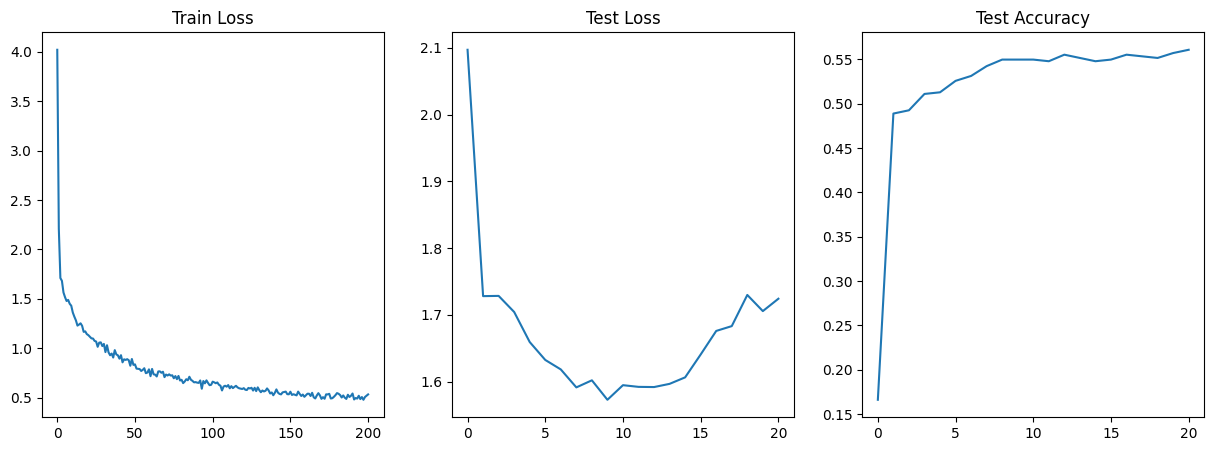

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title("Train Loss")
plt.subplot(1, 3, 2)
plt.plot(test_loss)
plt.title("Test Loss")
plt.subplot(1, 3, 3)
plt.plot(test_acc)
plt.title("Test Accuracy")
plt.show()
